# 🤗 HuggingFace Neural Network Notebook - CV Split

Sources:
1. [Originally based on cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

## Version History

### 1.0
Base implementation following [cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

### 2.0
1. Sliding window technique
2. wandb logging
3. Threshold

## Setup

### Environment Variables

In [1]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


### Import Libraries

In [2]:
import gc
import os
import random
import time
from typing import Tuple, List
import warnings
import pickle as pkl

from dotenv import load_dotenv
import wandb
from tqdm import tqdm
import torch
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    PreTrainedTokenizer,
)
from datasets import Dataset
from tokenizers import AddedToken
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
)

In [3]:
os.chdir("../../")
warnings.simplefilter('ignore')
load_dotenv()

True

In [4]:
from lib.criterion.metrics import log_metrics
from lib.utils.find_threshold import find_thresholds

### Paths

In [5]:
class Paths:
    # Competition data with added topic column
    train_csv: str = "data/processed/train.csv"
    test_csv: str = "data/processed/test.csv"

    # Output path
    output_path: str = "output/model_dir_cv"
    model_path: str = os.path.join(output_path, "{model_name}_fold_{fold}")
    tokenizer_path: str =  os.path.join(output_path, "{model_name}_tokenizer")
    oof_path: str = os.path.join(output_path, "valid_df_fold_{fold}.csv")
    threshold_path: str = os.path.join(output_path, "threshold.pkl")
    logging_path: str = os.path.join(output_path, "logging")

### Configurations

In [6]:
DEBUG = False
DO_SLIDING_WINDOW = True
DO_REGRESSION = True

In [7]:
class CFG:
    backbone_model: str = "microsoft/deberta-v3-large"
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = True
    lr: float = 2e-5
    lr_scheduler_type: str = "cosine"
    max_length: int = 512
    n_splits: int = 7
    num_labels: int = 6
    num_folds: int = 7
    num_epochs: int = 3
    num_workers: int = 6
    seed: int = 20
    stride_length: int = 384
    train_batch_size: int = 16
    valid_batch_size: int = 32
    weight_decay: float = 0.03
    warmup_ratio: float = 0.01
    train_folds: List[int] = list(range(num_folds))

In [8]:
if DEBUG:
    CFG.num_epochs = 1
    CFG.train_folds = [0]

In [9]:
MODEL_NAME = CFG.backbone_model.split("/")[-1]

### Setting Random Seed

In [10]:
def seed_everything() -> None:
    """Seed everything to ensure reproducibility

    Sources:
    1. https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train
    2. https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
    """
    random.seed(CFG.seed)
    os.environ["PYTHONHASHCFG.SEED"] = str(CFG.seed)
    np.random.seed(CFG.seed)
    torch.manual_seed(CFG.seed)
    torch.cuda.manual_seed(CFG.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

### WandB setup

In [11]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
type = "R" if DO_REGRESSION else "C"
WANDB_NAME = f"{MODEL_NAME}-{CFG.max_length}-{type}-CV"

In [12]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## Data Preparation

### Tokenizer

In [13]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid

    def get_dataset(self, df):
        ds = Dataset.from_dict(
            {
                "essay_id": [e for e in df["essay_id"]],
                "full_text": [ft for ft in df["full_text"]],
                "label": [s for s in df["label"]],
            }
        )
        return ds

    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example["full_text"],
            truncation=True,
            max_length=CFG.max_length,
            padding="max_length",
            
        )
        return tokenized_inputs

    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)

        tokenized_train = train_ds.map(self.tokenize_function, batched=True)
        tokenized_valid = valid_ds.map(self.tokenize_function, batched=True)

        return tokenized_train, tokenized_valid, self.tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(CFG.backbone_model)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" " * 2, normalized=False)])
tokenizer.save_pretrained(Paths.tokenizer_path.format(model_name=MODEL_NAME))

('output/model_dir_cv/deberta-v3-large_tokenizer/tokenizer_config.json',
 'output/model_dir_cv/deberta-v3-large_tokenizer/special_tokens_map.json',
 'output/model_dir_cv/deberta-v3-large_tokenizer/spm.model',
 'output/model_dir_cv/deberta-v3-large_tokenizer/added_tokens.json',
 'output/model_dir_cv/deberta-v3-large_tokenizer/tokenizer.json')

### Data Preprocessing

1. Convert `label` to be in `scores` which are processed to be in range $[0-5]$.
2. Convert `label` data type based on whether we are doing regression or classification.

In [15]:
data = pd.read_csv(Paths.train_csv, low_memory=False)
print("Training dataset has shape:", data.shape)

data["label"] = data["score"].map(lambda x: x- 1)

if DO_REGRESSION:
    data["label"] = data["label"].astype(pd.Float32Dtype())
else:
    data["label"] = data["label"].astype(pd.Int32Dtype())

data.head(3)

Training dataset has shape: (17307, 4)


,essay_id,full_text,score,topic,label
0,000d118,Many people have car where they live. The thin...,3,5,2.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0


### Train-Valid Splitting

In [16]:
skf = StratifiedGroupKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)

for i, (_, val_index) in enumerate(skf.split(data, data["label"], data["topic"])):
    data.loc[val_index, "fold"] = i

data.head(3)

,essay_id,full_text,score,topic,label,fold
0,000d118,Many people have car where they live. The thin...,3,5,2.0,1.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0,5.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0,4.0


### Sliding Window

Essays can have varying lengths. Instead of truncating, see the entire essay as windows of length `CFG.max_length` which are strided with `CFG.stride_length`.

In [17]:
def construct_new_row(old_row, text):
    new_row = {key: old_row[key] for key in old_row.keys() if key != "index"}
    new_row["full_text"] = text
    return new_row

In [18]:
def split_tokens(tokens, stride):
    """Splits `tokens` into multiple sequences that have at most
    `CFG.max_length` tokens. Uses `CFG.stride` for sliding
    window.

    Args:
        tokens (List): List of tokens.
        stride (int): Stride length.

    Returns:
        List[List[int]]: List of split token sequences.
    """
    start = 0
    sequence_list = []

    while start < len(tokens):
        remaining_tokens = len(tokens) - start

        if remaining_tokens < CFG.max_length and start > 0:
            start = max(0, len(tokens) - CFG.max_length)

        end = min(start + CFG.max_length, len(tokens))
        sequence_list.append(tokens[start:end])

        if remaining_tokens >= CFG.max_length:
            start += stride
        else:
            break

    return sequence_list

In [19]:
def sliding_window(df, tokenizer):
    """Splits rows of `df` so that each row's text has at most
    `CFG.max_length` number of tokens.

    Args:
        df (pd.DataFrame): Input data frame.
        tokenizer (_type_): Tokenizer used to encode and decode text.

    Returns:
        pd.DataFrame: Newly constructed dataframe.
    """

    new_df = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        tokens = tokenizer.encode(row["full_text"], add_special_tokens=False)

        if len(tokens) <= CFG.max_length:
            new_df.append(construct_new_row(row, row["full_text"]))
        else:
            sequence_list = split_tokens(tokens, CFG.stride_length)

            for seq in sequence_list:
                new_df.append(
                    construct_new_row(
                        row,
                        tokenizer.decode(seq, skip_special_tokens=True),
                    )
                )

    return pd.DataFrame(new_df)

In [20]:
if DO_SLIDING_WINDOW:
    data = sliding_window(data, tokenizer)
    data.head(3)

100%|██████████| 17307/17307 [00:40<00:00, 428.06it/s]


## Metrics

### QWK Score Calculation

In [21]:
def compute_metrics_for_regression(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.clip(0, 5).round(0),
        weights="quadratic",
    )

    return {"qwk": qwk}

In [22]:
def compute_metrics_for_classification(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.argmax(-1),
        weights="quadratic",
    )
    
    return {"qwk": qwk}

In [23]:
if DO_REGRESSION:
    compute_metrics = compute_metrics_for_regression
else:
    compute_metrics = compute_metrics_for_classification

### WandB Metric Logging

In [24]:
def plot_wandb_bar(data, label, value, id, title):
    table = wandb.Table(data=data, columns=[label, value])
    wandb.log({id: wandb.plot.bar(table, label, value, title=title)})

In [25]:
def plot_metrics(prefix, precision_data, recall_data, f1_data):
    plot_wandb_bar(
        f1_data,
        "score",
        "F1 Score",
        f"{prefix}/F1 Score",
        f"F1 score for {prefix}",
    )
    plot_wandb_bar(
        recall_data,
        "score",
        "Recall",
        f"{prefix}/Recall",
        f"Recall for {prefix}",
    )
    plot_wandb_bar(
        precision_data,
        "score",
        "Precision",
        f"{prefix}/Precision",
        f"Precision for {prefix}",
    )

In [26]:
def calcluate_metrics(df):
    precision_data = [None for _ in range(CFG.num_labels)]
    recall_data = [None for _ in range(CFG.num_labels)]
    f1_data = [None for _ in range(CFG.num_labels)]

    for label in range(CFG.num_labels):
        tp = df.loc[(df.label == label) & (df.label == df.pred_score), "label"].count()
        fp = df.loc[(df.label != label) & (df.pred_score == label), "label"].count()
        tn = df.loc[(df.label != label) & (df.pred_score != label), "label"].count()
        fn = df.loc[(df.label == label) & (df.pred_score != label), "label"].count()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)

        precision_data[label] = (label, precision)
        recall_data[label] = (label, recall)
        f1_data[label] = (label, f1)

    return precision_data, recall_data, f1_data

In [27]:
def log_metrics(df, prefix):
    wandb.log(
        {
            f"{prefix}/conf_mat": wandb.plot.confusion_matrix(
                probs=None,
                y_true=df["label"].astype(pd.Int32Dtype()),
                preds=df["pred_score"].astype(pd.Int32Dtype()),
                class_names=list(range(CFG.num_labels)),
            )
        }
    )

    precision_data, recall_data, f1_data = calcluate_metrics(df)
    plot_metrics(prefix, precision_data, recall_data, f1_data)

## Training

### Training Arguments

In [28]:
training_args = TrainingArguments(
    data_seed=CFG.seed,
    dataloader_num_workers=CFG.num_workers,
    evaluation_strategy="epoch",
    fp16=True,
    gradient_checkpointing=CFG.gradient_checkpointing,
    gradient_accumulation_steps=CFG.gradient_accumulation_steps,
    learning_rate=CFG.lr,
    load_best_model_at_end=True,
    logging_first_step=True,
    logging_steps=50,
    logging_dir=Paths.logging_path,
    lr_scheduler_type=CFG.lr_scheduler_type,
    metric_for_best_model="qwk",
    num_train_epochs=CFG.num_epochs,
    output_dir=Paths.output_path,
    optim="adamw_torch",
    per_device_eval_batch_size=CFG.valid_batch_size,
    per_device_train_batch_size=CFG.train_batch_size,
    report_to="wandb",
    seed=CFG.seed,
    save_strategy="epoch",
    save_total_limit=1,
    weight_decay=CFG.weight_decay,
    warmup_ratio=CFG.warmup_ratio,
)

### Utility Functions

In [29]:
def get_fold_data(fold: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = data[data["fold"] != fold].reset_index(drop=True)
    valid = data[data["fold"] == fold].reset_index(drop=True)
    return train, valid

In [30]:
def tokenize_data(train: pd.DataFrame, valid: pd.DataFrame) -> Tuple[Dataset, Dataset]:
    tokenize = Tokenize(train, valid, tokenizer)
    tokenized_train, tokenized_valid, _ = tokenize()
    return tokenized_train, tokenized_valid

In [31]:
def configure():
    config = AutoConfig.from_pretrained(CFG.backbone_model)
    
    if DO_REGRESSION:
        config.attention_probs_dropout_prob = 0.0
        config.hidden_dropout_prob = 0.0
        config.num_labels = 1
    else:
        config.num_labels = CFG.num_labels

    return config

In [32]:
def get_model(config):
    backbone_model = AutoModelForSequenceClassification.from_pretrained(
        CFG.backbone_model,
        config=config,
    )
    backbone_model.resize_token_embeddings(len(tokenizer))
    return backbone_model

In [33]:
def post_process_predictions(predictions0):
    if DO_REGRESSION:
        predictions = predictions0.clip(0, 5).round(0)
    else:
        predictions = predictions0.argmax(axis=1)

    return predictions

In [34]:
def plot_confusion_matrxi(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[x for x in range(CFG.num_labels)])
    draw_cm = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=[x for x in range(CFG.num_labels)]
    )
    draw_cm.plot()
    plt.show()

In [35]:
def save_oof_predictions(fold, valid, logits, y_pred):
    if DO_REGRESSION:
        valid["logit"] = logits
    else:
        COLS = [f"p{x}" for x in range(CFG.num_labels)]
        valid[COLS] = logits

    valid["pred_score"] = y_pred
    valid.to_csv(Paths.oof_path.format(fold=fold), index=False)
    return valid

### CV Training Fold Loop

In [36]:
scores = []

for fold in CFG.train_folds:
    train, valid = get_fold_data(fold)

    tokenized_train, tokenized_valid = tokenize_data(train, valid)

    config = configure()

    backbone_model = get_model(config)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=backbone_model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_valid,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    y_true = valid["label"].values
    logits = trainer.predict(tokenized_valid).predictions
    y_pred = post_process_predictions(logits)

    trainer.save_model(Paths.model_path.format(model_name=MODEL_NAME, fold=fold))

    oof_df = save_oof_predictions(fold, valid, logits, y_pred)
    log_metrics(oof_df, f"Fold {fold}")

    score = compute_metrics((oof_df["pred_score"], oof_df["label"]))
    scores.append((fold, score))

    del (
        train,
        valid,
        tokenized_train,
        tokenized_valid,
        backbone_model,
        data_collator,
        trainer,
        y_pred,
        y_true,
        logits,
    )
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(5)

Map:   0%|          | 0/18959 [00:00<?, ? examples/s]

Map:   0%|          | 0/3788 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3555 [00:00<?, ?it/s]

{'loss': 6.0466, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 3.5072, 'grad_norm': 16.84636116027832, 'learning_rate': 1.9999677214588314e-05, 'epoch': 0.04}
{'loss': 0.6029, 'grad_norm': 40.37558364868164, 'learning_rate': 1.998613132953312e-05, 'epoch': 0.08}
{'loss': 0.7236, 'grad_norm': 30.22718620300293, 'learning_rate': 1.9952691248998676e-05, 'epoch': 0.13}
{'loss': 0.5214, 'grad_norm': 9.517505645751953, 'learning_rate': 1.989942359172622e-05, 'epoch': 0.17}
{'loss': 0.4878, 'grad_norm': 5.510385990142822, 'learning_rate': 1.9826434476607198e-05, 'epoch': 0.21}
{'loss': 0.4278, 'grad_norm': 3.7511141300201416, 'learning_rate': 1.9733869311275063e-05, 'epoch': 0.25}
{'loss': 0.4688, 'grad_norm': 22.68305015563965, 'learning_rate': 1.962191250242676e-05, 'epoch': 0.3}
{'loss': 0.5014, 'grad_norm': 11.843547821044922, 'learning_rate': 1.9490787088450922e-05, 'epoch': 0.34}
{'loss': 0.4357, 'grad_norm': 8.748495101928711, 'learning_rate': 1.9340754295094726e-05, '

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.45948174595832825, 'eval_qwk': 0.7621010044943256, 'eval_runtime': 68.8094, 'eval_samples_per_second': 55.051, 'eval_steps_per_second': 1.729, 'epoch': 1.0}
{'loss': 0.2848, 'grad_norm': 4.929188251495361, 'learning_rate': 1.5107847025681048e-05, 'epoch': 1.01}
{'loss': 0.2426, 'grad_norm': 3.963155746459961, 'learning_rate': 1.4719133455144252e-05, 'epoch': 1.05}
{'loss': 0.2344, 'grad_norm': 4.878218173980713, 'learning_rate': 1.4321018509805617e-05, 'epoch': 1.1}
{'loss': 0.2121, 'grad_norm': 17.724252700805664, 'learning_rate': 1.3914295307268396e-05, 'epoch': 1.14}
{'loss': 0.2026, 'grad_norm': 11.171797752380371, 'learning_rate': 1.3499774114354655e-05, 'epoch': 1.18}
{'loss': 0.2192, 'grad_norm': 5.795461177825928, 'learning_rate': 1.3078280732905976e-05, 'epoch': 1.22}
{'loss': 0.2431, 'grad_norm': 8.178966522216797, 'learning_rate': 1.2650654854635498e-05, 'epoch': 1.27}
{'loss': 0.2117, 'grad_norm': 5.848771572113037, 'learning_rate': 1.2217748388308844e-05, '

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.5665403008460999, 'eval_qwk': 0.7596475667800836, 'eval_runtime': 68.8014, 'eval_samples_per_second': 55.057, 'eval_steps_per_second': 1.73, 'epoch': 2.0}
{'loss': 0.1041, 'grad_norm': 2.5112032890319824, 'learning_rate': 4.899830071092442e-06, 'epoch': 2.03}
{'loss': 0.0775, 'grad_norm': 4.302321434020996, 'learning_rate': 4.5210812880514485e-06, 'epoch': 2.07}
{'loss': 0.0784, 'grad_norm': 2.6680896282196045, 'learning_rate': 4.153247510659151e-06, 'epoch': 2.11}
{'loss': 0.0696, 'grad_norm': 3.4516382217407227, 'learning_rate': 3.7970615309077364e-06, 'epoch': 2.15}
{'loss': 0.0754, 'grad_norm': 2.832540273666382, 'learning_rate': 3.453232936251485e-06, 'epoch': 2.19}
{'loss': 0.0686, 'grad_norm': 2.5004827976226807, 'learning_rate': 3.1224466959790676e-06, 'epoch': 2.24}
{'loss': 0.0634, 'grad_norm': 2.0737149715423584, 'learning_rate': 2.8053617966297908e-06, 'epoch': 2.28}
{'loss': 0.0628, 'grad_norm': 5.926382541656494, 'learning_rate': 2.5026099291721517e-06, 'e

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.4586372375488281, 'eval_qwk': 0.7879682479352201, 'eval_runtime': 69.5894, 'eval_samples_per_second': 54.434, 'eval_steps_per_second': 1.71, 'epoch': 3.0}
{'train_runtime': 4205.7781, 'train_samples_per_second': 13.524, 'train_steps_per_second': 0.845, 'train_loss': 0.2713328214637338, 'epoch': 3.0}


  0%|          | 0/119 [00:00<?, ?it/s]

Map:   0%|          | 0/19638 [00:00<?, ? examples/s]

Map:   0%|          | 0/3109 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3684 [00:00<?, ?it/s]

{'loss': 7.4537, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 2.7176, 'grad_norm': 26.14816665649414, 'learning_rate': 1.9999628981523677e-05, 'epoch': 0.04}
{'loss': 0.6187, 'grad_norm': 6.8150553703308105, 'learning_rate': 1.9986646225372382e-05, 'epoch': 0.08}
{'loss': 0.5684, 'grad_norm': 30.151098251342773, 'learning_rate': 1.9955140067165346e-05, 'epoch': 0.12}
{'loss': 0.5175, 'grad_norm': 9.14035415649414, 'learning_rate': 1.9905168945063136e-05, 'epoch': 0.16}
{'loss': 0.474, 'grad_norm': 7.134177207946777, 'learning_rate': 1.9836825546356862e-05, 'epoch': 0.2}
{'loss': 0.4461, 'grad_norm': 13.281290054321289, 'learning_rate': 1.9750236635550194e-05, 'epoch': 0.24}
{'loss': 0.4345, 'grad_norm': 4.513244152069092, 'learning_rate': 1.96455628192344e-05, 'epoch': 0.29}
{'loss': 0.3935, 'grad_norm': 10.208441734313965, 'learning_rate': 1.952299824819249e-05, 'epoch': 0.33}
{'loss': 0.4361, 'grad_norm': 7.052241802215576, 'learning_rate': 1.9382770257285033e-05, '

  0%|          | 0/98 [00:00<?, ?it/s]

{'eval_loss': 0.4641028344631195, 'eval_qwk': 0.710947098612187, 'eval_runtime': 58.037, 'eval_samples_per_second': 53.569, 'eval_steps_per_second': 1.689, 'epoch': 1.0}
{'loss': 0.2821, 'grad_norm': 4.657806396484375, 'learning_rate': 1.5042214171745598e-05, 'epoch': 1.02}
{'loss': 0.2638, 'grad_norm': 4.346651077270508, 'learning_rate': 1.4665703555634907e-05, 'epoch': 1.06}
{'loss': 0.252, 'grad_norm': 7.284741401672363, 'learning_rate': 1.4280538912848636e-05, 'epoch': 1.1}
{'loss': 0.2235, 'grad_norm': 6.029150485992432, 'learning_rate': 1.3887434653347347e-05, 'epoch': 1.14}
{'loss': 0.231, 'grad_norm': 6.214317798614502, 'learning_rate': 1.348711991362834e-05, 'epoch': 1.18}
{'loss': 0.2295, 'grad_norm': 5.235035419464111, 'learning_rate': 1.3080337204310827e-05, 'epoch': 1.22}
{'loss': 0.2363, 'grad_norm': 5.652911186218262, 'learning_rate': 1.266784103291455e-05, 'epoch': 1.26}
{'loss': 0.2197, 'grad_norm': 7.8504719734191895, 'learning_rate': 1.225039650438633e-05, 'epoch': 1

  0%|          | 0/98 [00:00<?, ?it/s]

{'eval_loss': 0.5719500780105591, 'eval_qwk': 0.6904300778979819, 'eval_runtime': 56.218, 'eval_samples_per_second': 55.303, 'eval_steps_per_second': 1.743, 'epoch': 2.0}
{'loss': 0.0986, 'grad_norm': 3.7600460052490234, 'learning_rate': 4.787689894371692e-06, 'epoch': 2.04}
{'loss': 0.0801, 'grad_norm': 2.0803322792053223, 'learning_rate': 4.425063539834341e-06, 'epoch': 2.08}
{'loss': 0.0837, 'grad_norm': 2.1344029903411865, 'learning_rate': 4.072777672699508e-06, 'epoch': 2.12}
{'loss': 0.0797, 'grad_norm': 3.5655508041381836, 'learning_rate': 3.7314857188128927e-06, 'epoch': 2.16}
{'loss': 0.0728, 'grad_norm': 5.241758823394775, 'learning_rate': 3.4018207123220503e-06, 'epoch': 2.2}
{'loss': 0.075, 'grad_norm': 5.508511066436768, 'learning_rate': 3.084394121513845e-06, 'epoch': 2.24}
{'loss': 0.0731, 'grad_norm': 1.8170607089996338, 'learning_rate': 2.7797947146526195e-06, 'epoch': 2.28}
{'loss': 0.0803, 'grad_norm': 3.58601450920105, 'learning_rate': 2.4885874679227617e-06, 'epoch

  0%|          | 0/98 [00:00<?, ?it/s]

{'eval_loss': 0.4821445941925049, 'eval_qwk': 0.7316397965665009, 'eval_runtime': 55.6339, 'eval_samples_per_second': 55.883, 'eval_steps_per_second': 1.762, 'epoch': 3.0}
{'train_runtime': 4291.811, 'train_samples_per_second': 13.727, 'train_steps_per_second': 0.858, 'train_loss': 0.26017614684586415, 'epoch': 3.0}


  0%|          | 0/98 [00:00<?, ?it/s]

Map:   0%|          | 0/18892 [00:00<?, ? examples/s]

Map:   0%|          | 0/3855 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3543 [00:00<?, ?it/s]

{'loss': 6.2072, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 2.895, 'grad_norm': 11.693952560424805, 'learning_rate': 1.9999598768229937e-05, 'epoch': 0.04}
{'loss': 0.6354, 'grad_norm': 35.46957778930664, 'learning_rate': 1.998555903671379e-05, 'epoch': 0.08}
{'loss': 0.6495, 'grad_norm': 11.457828521728516, 'learning_rate': 1.9951489902469014e-05, 'epoch': 0.13}
{'loss': 0.4929, 'grad_norm': 18.70824432373047, 'learning_rate': 1.989745970262204e-05, 'epoch': 0.17}
{'loss': 0.4998, 'grad_norm': 11.975519180297852, 'learning_rate': 1.982357681294114e-05, 'epoch': 0.21}
{'loss': 0.4839, 'grad_norm': 17.81357192993164, 'learning_rate': 1.972998943045231e-05, 'epoch': 0.25}
{'loss': 0.4843, 'grad_norm': 10.836403846740723, 'learning_rate': 1.9616885276180216e-05, 'epoch': 0.3}
{'loss': 0.4567, 'grad_norm': 14.13190746307373, 'learning_rate': 1.9484491218610423e-05, 'epoch': 0.34}
{'loss': 0.4298, 'grad_norm': 15.209813117980957, 'learning_rate': 1.9333072818628222e-05, 

  0%|          | 0/121 [00:00<?, ?it/s]

{'eval_loss': 0.36777547001838684, 'eval_qwk': 0.8030443511406266, 'eval_runtime': 68.5937, 'eval_samples_per_second': 56.201, 'eval_steps_per_second': 1.764, 'epoch': 1.0}
{'loss': 0.2514, 'grad_norm': 4.656144618988037, 'learning_rate': 1.5069657934773085e-05, 'epoch': 1.02}
{'loss': 0.2385, 'grad_norm': 4.358079433441162, 'learning_rate': 1.4678625198653875e-05, 'epoch': 1.06}
{'loss': 0.2322, 'grad_norm': 3.404064893722534, 'learning_rate': 1.4278207903495388e-05, 'epoch': 1.1}
{'loss': 0.2605, 'grad_norm': 5.702356815338135, 'learning_rate': 1.3869209221081483e-05, 'epoch': 1.14}
{'loss': 0.2493, 'grad_norm': 5.808937072753906, 'learning_rate': 1.3452449536059164e-05, 'epoch': 1.19}
{'loss': 0.2385, 'grad_norm': 5.693689346313477, 'learning_rate': 1.3028764800380818e-05, 'epoch': 1.23}
{'loss': 0.2609, 'grad_norm': 5.612465858459473, 'learning_rate': 1.2599004856520926e-05, 'epoch': 1.27}
{'loss': 0.235, 'grad_norm': 4.380953311920166, 'learning_rate': 1.216403173283069e-05, 'epoc

  0%|          | 0/121 [00:00<?, ?it/s]

{'eval_loss': 0.3404313921928406, 'eval_qwk': 0.8218400129667096, 'eval_runtime': 68.7873, 'eval_samples_per_second': 56.042, 'eval_steps_per_second': 1.759, 'epoch': 2.0}
{'loss': 0.1061, 'grad_norm': 2.5054826736450195, 'learning_rate': 4.83797819417937e-06, 'epoch': 2.03}
{'loss': 0.0916, 'grad_norm': 6.451237201690674, 'learning_rate': 4.45966938007443e-06, 'epoch': 2.07}
{'loss': 0.0906, 'grad_norm': 7.487259864807129, 'learning_rate': 4.092473565534997e-06, 'epoch': 2.12}
{'loss': 0.0866, 'grad_norm': 10.958023071289062, 'learning_rate': 3.7371272854733855e-06, 'epoch': 2.16}
{'loss': 0.0857, 'grad_norm': 4.700131893157959, 'learning_rate': 3.3943433065685006e-06, 'epoch': 2.2}
{'loss': 0.0799, 'grad_norm': 4.102060317993164, 'learning_rate': 3.064809197572084e-06, 'epoch': 2.24}
{'loss': 0.0757, 'grad_norm': 3.171873092651367, 'learning_rate': 2.749185950157983e-06, 'epoch': 2.29}
{'loss': 0.0799, 'grad_norm': 4.461956024169922, 'learning_rate': 2.44810665308064e-06, 'epoch': 2.

  0%|          | 0/121 [00:00<?, ?it/s]

{'eval_loss': 0.38347890973091125, 'eval_qwk': 0.8104404551701085, 'eval_runtime': 68.598, 'eval_samples_per_second': 56.197, 'eval_steps_per_second': 1.764, 'epoch': 3.0}
{'train_runtime': 4128.74, 'train_samples_per_second': 13.727, 'train_steps_per_second': 0.858, 'train_loss': 0.2769367612757455, 'epoch': 3.0}


  0%|          | 0/121 [00:00<?, ?it/s]

Map:   0%|          | 0/20923 [00:00<?, ? examples/s]

Map:   0%|          | 0/1824 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3924 [00:00<?, ?it/s]

{'loss': 5.7821, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 3.2992, 'grad_norm': 39.4379997253418, 'learning_rate': 1.9999882235889635e-05, 'epoch': 0.04}
{'loss': 0.6133, 'grad_norm': 8.395864486694336, 'learning_rate': 1.998974317121727e-05, 'epoch': 0.08}
{'loss': 0.4586, 'grad_norm': 11.893623352050781, 'learning_rate': 1.99632669511918e-05, 'epoch': 0.11}
{'loss': 0.5656, 'grad_norm': 31.394027709960938, 'learning_rate': 1.9920496874836268e-05, 'epoch': 0.15}
{'loss': 0.4651, 'grad_norm': 10.271514892578125, 'learning_rate': 1.9861502888031153e-05, 'epoch': 0.19}
{'loss': 0.418, 'grad_norm': 4.674680709838867, 'learning_rate': 1.9786381469125378e-05, 'epoch': 0.23}
{'loss': 0.5192, 'grad_norm': 3.3946495056152344, 'learning_rate': 1.9695255471156298e-05, 'epoch': 0.27}
{'loss': 0.4702, 'grad_norm': 9.730781555175781, 'learning_rate': 1.9588273920936724e-05, 'epoch': 0.31}
{'loss': 0.3863, 'grad_norm': 13.054981231689453, 'learning_rate': 1.94656117753375e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.3450387120246887, 'eval_qwk': 0.6447599773032107, 'eval_runtime': 32.5888, 'eval_samples_per_second': 55.97, 'eval_steps_per_second': 1.749, 'epoch': 1.0}
{'loss': 0.2642, 'grad_norm': 3.6195149421691895, 'learning_rate': 1.4920402280960904e-05, 'epoch': 1.03}
{'loss': 0.2714, 'grad_norm': 9.474109649658203, 'learning_rate': 1.4564391430163474e-05, 'epoch': 1.07}
{'loss': 0.2731, 'grad_norm': 6.7950119972229, 'learning_rate': 1.4200916005892141e-05, 'epoch': 1.11}
{'loss': 0.2501, 'grad_norm': 3.674868106842041, 'learning_rate': 1.3830570433285932e-05, 'epoch': 1.15}
{'loss': 0.2263, 'grad_norm': 3.655850410461426, 'learning_rate': 1.3453960372875881e-05, 'epoch': 1.19}
{'loss': 0.2389, 'grad_norm': 4.562559127807617, 'learning_rate': 1.3071701730092088e-05, 'epoch': 1.22}
{'loss': 0.2094, 'grad_norm': 5.2036848068237305, 'learning_rate': 1.2684419648016334e-05, 'epoch': 1.26}
{'loss': 0.21, 'grad_norm': 14.54428768157959, 'learning_rate': 1.2292747485027498e-05, 'epoch

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.486769437789917, 'eval_qwk': 0.6043136791631006, 'eval_runtime': 32.7781, 'eval_samples_per_second': 55.647, 'eval_steps_per_second': 1.739, 'epoch': 2.0}
{'loss': 0.1047, 'grad_norm': 2.0459911823272705, 'learning_rate': 4.8837097102184864e-06, 'epoch': 2.03}
{'loss': 0.0803, 'grad_norm': 6.577542304992676, 'learning_rate': 4.540501299541356e-06, 'epoch': 2.06}
{'loss': 0.0803, 'grad_norm': 4.625548362731934, 'learning_rate': 4.206221314439416e-06, 'epoch': 2.1}
{'loss': 0.0904, 'grad_norm': 2.644449472427368, 'learning_rate': 3.8814164340368806e-06, 'epoch': 2.14}
{'loss': 0.0771, 'grad_norm': 2.9139726161956787, 'learning_rate': 3.5666178419387464e-06, 'epoch': 2.18}
{'loss': 0.0728, 'grad_norm': 5.165752410888672, 'learning_rate': 3.2623403575368493e-06, 'epoch': 2.22}
{'loss': 0.0736, 'grad_norm': 1.153062343597412, 'learning_rate': 2.969081594077886e-06, 'epoch': 2.26}
{'loss': 0.0714, 'grad_norm': 2.7418575286865234, 'learning_rate': 2.6873211448702363e-06, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.46028849482536316, 'eval_qwk': 0.6247901663318682, 'eval_runtime': 32.5291, 'eval_samples_per_second': 56.073, 'eval_steps_per_second': 1.752, 'epoch': 3.0}
{'train_runtime': 4440.2461, 'train_samples_per_second': 14.136, 'train_steps_per_second': 0.884, 'train_loss': 0.26626836542689475, 'epoch': 3.0}


  0%|          | 0/57 [00:00<?, ?it/s]

wandb: Network error (ConnectionError), entering retry loop.


Map:   0%|          | 0/17996 [00:00<?, ? examples/s]

Map:   0%|          | 0/4751 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3375 [00:00<?, ?it/s]

{'loss': 5.3351, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 2.8135, 'grad_norm': 55.12452697753906, 'learning_rate': 1.9999363388202554e-05, 'epoch': 0.04}
{'loss': 0.6438, 'grad_norm': 10.304142951965332, 'learning_rate': 1.9983010634250762e-05, 'epoch': 0.09}
{'loss': 0.559, 'grad_norm': 32.326690673828125, 'learning_rate': 1.994459468877063e-05, 'epoch': 0.13}
{'loss': 0.5183, 'grad_norm': 8.132916450500488, 'learning_rate': 1.988420045384169e-05, 'epoch': 0.18}
{'loss': 0.5092, 'grad_norm': 23.172042846679688, 'learning_rate': 1.980196140518798e-05, 'epoch': 0.22}
{'loss': 0.4689, 'grad_norm': 4.989927768707275, 'learning_rate': 1.969805929718681e-05, 'epoch': 0.27}
{'loss': 0.499, 'grad_norm': 9.667501449584961, 'learning_rate': 1.9572723761178168e-05, 'epoch': 0.31}
{'loss': 0.4894, 'grad_norm': 8.021368026733398, 'learning_rate': 1.942623179796247e-05, 'epoch': 0.36}
{'loss': 0.4425, 'grad_norm': 3.645915985107422, 'learning_rate': 1.9258907165608326e-05, 'ep

  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.33491072058677673, 'eval_qwk': 0.751195832073134, 'eval_runtime': 84.9614, 'eval_samples_per_second': 55.92, 'eval_steps_per_second': 1.754, 'epoch': 1.0}
{'loss': 0.3097, 'grad_norm': 2.970433473587036, 'learning_rate': 1.5013566133210317e-05, 'epoch': 1.02}
{'loss': 0.2356, 'grad_norm': 8.264913558959961, 'learning_rate': 1.460137635484654e-05, 'epoch': 1.07}
{'loss': 0.264, 'grad_norm': 11.552536964416504, 'learning_rate': 1.4179017194566786e-05, 'epoch': 1.11}
{'loss': 0.2604, 'grad_norm': 5.3705735206604, 'learning_rate': 1.3747422097339553e-05, 'epoch': 1.16}
{'loss': 0.2607, 'grad_norm': 9.525503158569336, 'learning_rate': 1.3307544920236788e-05, 'epoch': 1.2}
{'loss': 0.2402, 'grad_norm': 6.778589725494385, 'learning_rate': 1.2860357824339246e-05, 'epoch': 1.24}
{'loss': 0.2407, 'grad_norm': 2.199359178543091, 'learning_rate': 1.2406849126188628e-05, 'epoch': 1.29}
{'loss': 0.2723, 'grad_norm': 4.348560333251953, 'learning_rate': 1.1948021113534948e-05, 'epoch':

  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.40738990902900696, 'eval_qwk': 0.7312452991382887, 'eval_runtime': 84.6322, 'eval_samples_per_second': 56.137, 'eval_steps_per_second': 1.761, 'epoch': 2.0}
{'loss': 0.0869, 'grad_norm': 3.9090771675109863, 'learning_rate': 4.720402862234105e-06, 'epoch': 2.04}
{'loss': 0.09, 'grad_norm': 5.296076774597168, 'learning_rate': 4.327093684266895e-06, 'epoch': 2.09}
{'loss': 0.0857, 'grad_norm': 2.2177724838256836, 'learning_rate': 3.946322048645573e-06, 'epoch': 2.13}
{'loss': 0.0844, 'grad_norm': 1.8957266807556152, 'learning_rate': 3.578929488834646e-06, 'epoch': 2.18}
{'loss': 0.0833, 'grad_norm': 6.75679874420166, 'learning_rate': 3.2257279695519915e-06, 'epoch': 2.22}
{'loss': 0.0845, 'grad_norm': 2.9724295139312744, 'learning_rate': 2.887498092266798e-06, 'epoch': 2.27}
{'loss': 0.0798, 'grad_norm': 3.080284357070923, 'learning_rate': 2.5649873700126137e-06, 'epoch': 2.31}
{'loss': 0.0815, 'grad_norm': 2.2881665229797363, 'learning_rate': 2.258908575328281e-06, 'epoch

  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.33483561873435974, 'eval_qwk': 0.7560216903749215, 'eval_runtime': 84.8942, 'eval_samples_per_second': 55.964, 'eval_steps_per_second': 1.755, 'epoch': 3.0}
{'train_runtime': 3994.1346, 'train_samples_per_second': 13.517, 'train_steps_per_second': 0.845, 'train_loss': 0.27967847223635073, 'epoch': 3.0}


  0%|          | 0/149 [00:00<?, ?it/s]

Map:   0%|          | 0/20196 [00:00<?, ? examples/s]

Map:   0%|          | 0/2551 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3789 [00:00<?, ?it/s]

{'loss': 6.4134, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 2.8925, 'grad_norm': 7.799527645111084, 'learning_rate': 1.9999775532241056e-05, 'epoch': 0.04}
{'loss': 0.6602, 'grad_norm': 5.542455673217773, 'learning_rate': 1.998820368922582e-05, 'epoch': 0.08}
{'loss': 0.5634, 'grad_norm': 18.27945899963379, 'learning_rate': 1.9959118483264944e-05, 'epoch': 0.12}
{'loss': 0.5722, 'grad_norm': 25.086027145385742, 'learning_rate': 1.991257091249425e-05, 'epoch': 0.16}
{'loss': 0.4871, 'grad_norm': 20.96141242980957, 'learning_rate': 1.9848642593641476e-05, 'epoch': 0.2}
{'loss': 0.4263, 'grad_norm': 3.0243923664093018, 'learning_rate': 1.976744561891914e-05, 'epoch': 0.24}
{'loss': 0.4868, 'grad_norm': 5.639791965484619, 'learning_rate': 1.9669122359481526e-05, 'epoch': 0.28}
{'loss': 0.4712, 'grad_norm': 5.8660125732421875, 'learning_rate': 1.9553845215790417e-05, 'epoch': 0.32}
{'loss': 0.547, 'grad_norm': 10.159919738769531, 'learning_rate': 1.9421816315327366e-05, 

  0%|          | 0/80 [00:00<?, ?it/s]

{'eval_loss': 0.8786149024963379, 'eval_qwk': 0.5961267114219497, 'eval_runtime': 45.5417, 'eval_samples_per_second': 56.015, 'eval_steps_per_second': 1.757, 'epoch': 1.0}
{'loss': 0.3001, 'grad_norm': 6.306370735168457, 'learning_rate': 1.4944288954578505e-05, 'epoch': 1.03}
{'loss': 0.2707, 'grad_norm': 5.724617958068848, 'learning_rate': 1.4576060513957959e-05, 'epoch': 1.07}
{'loss': 0.2811, 'grad_norm': 6.223255157470703, 'learning_rate': 1.4199808387484006e-05, 'epoch': 1.11}
{'loss': 0.221, 'grad_norm': 4.867225170135498, 'learning_rate': 1.3816192297390503e-05, 'epoch': 1.15}
{'loss': 0.2225, 'grad_norm': 5.430709362030029, 'learning_rate': 1.3425884877919457e-05, 'epoch': 1.19}
{'loss': 0.2556, 'grad_norm': 4.637945652008057, 'learning_rate': 1.3029570495921037e-05, 'epoch': 1.23}
{'loss': 0.2441, 'grad_norm': 3.279740571975708, 'learning_rate': 1.2627944050881525e-05, 'epoch': 1.27}
{'loss': 0.2607, 'grad_norm': 4.369043350219727, 'learning_rate': 1.2221709756483312e-05, 'epo

  0%|          | 0/80 [00:00<?, ?it/s]

{'eval_loss': 0.7335002422332764, 'eval_qwk': 0.6822337964191709, 'eval_runtime': 45.759, 'eval_samples_per_second': 55.749, 'eval_steps_per_second': 1.748, 'epoch': 2.0}
{'loss': 0.1512, 'grad_norm': 3.9785940647125244, 'learning_rate': 4.946904044918819e-06, 'epoch': 2.02}
{'loss': 0.0997, 'grad_norm': 5.502175331115723, 'learning_rate': 4.590069404477957e-06, 'epoch': 2.06}
{'loss': 0.105, 'grad_norm': 1.6901826858520508, 'learning_rate': 4.242720561581686e-06, 'epoch': 2.1}
{'loss': 0.081, 'grad_norm': 3.0724244117736816, 'learning_rate': 3.905466559311584e-06, 'epoch': 2.14}
{'loss': 0.0848, 'grad_norm': 2.3788228034973145, 'learning_rate': 3.5788987404085916e-06, 'epoch': 2.18}
{'loss': 0.0863, 'grad_norm': 1.6195429563522339, 'learning_rate': 3.263589710409881e-06, 'epoch': 2.22}
{'loss': 0.086, 'grad_norm': 2.6143345832824707, 'learning_rate': 2.9600923336396258e-06, 'epoch': 2.26}
{'loss': 0.0799, 'grad_norm': 2.5126614570617676, 'learning_rate': 2.668938763814134e-06, 'epoch'

  0%|          | 0/80 [00:00<?, ?it/s]

{'eval_loss': 0.9301013946533203, 'eval_qwk': 0.6091255914577567, 'eval_runtime': 45.5502, 'eval_samples_per_second': 56.004, 'eval_steps_per_second': 1.756, 'epoch': 3.0}
{'train_runtime': 4330.7854, 'train_samples_per_second': 13.99, 'train_steps_per_second': 0.875, 'train_loss': 0.2815923563689662, 'epoch': 3.0}


  0%|          | 0/80 [00:00<?, ?it/s]

Map:   0%|          | 0/19878 [00:00<?, ? examples/s]

Map:   0%|          | 0/2869 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3729 [00:00<?, ?it/s]

{'loss': 5.6326, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 2.881, 'grad_norm': 31.341188430786133, 'learning_rate': 1.999976817516716e-05, 'epoch': 0.04}
{'loss': 0.6437, 'grad_norm': 10.885871887207031, 'learning_rate': 1.9987817134649997e-05, 'epoch': 0.08}
{'loss': 0.5439, 'grad_norm': 18.2054386138916, 'learning_rate': 1.9957779503969486e-05, 'epoch': 0.12}
{'loss': 0.4317, 'grad_norm': 13.829374313354492, 'learning_rate': 1.990970967722478e-05, 'epoch': 0.16}
{'loss': 0.5196, 'grad_norm': 9.53882122039795, 'learning_rate': 1.9843694702390818e-05, 'epoch': 0.2}
{'loss': 0.4474, 'grad_norm': 11.768196105957031, 'learning_rate': 1.975985412368615e-05, 'epoch': 0.24}
{'loss': 0.3846, 'grad_norm': 5.800601482391357, 'learning_rate': 1.9658339765094508e-05, 'epoch': 0.28}
{'loss': 0.4042, 'grad_norm': 7.106357097625732, 'learning_rate': 1.953933545543201e-05, 'epoch': 0.32}
{'loss': 0.4749, 'grad_norm': 7.5212202072143555, 'learning_rate': 1.940305669545799e-05, 'ep

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.5890913009643555, 'eval_qwk': 0.7399490870103813, 'eval_runtime': 51.2757, 'eval_samples_per_second': 55.952, 'eval_steps_per_second': 1.755, 'epoch': 1.0}
{'loss': 0.3433, 'grad_norm': 10.463722229003906, 'learning_rate': 1.5163709566274807e-05, 'epoch': 1.01}
{'loss': 0.2519, 'grad_norm': 4.113266468048096, 'learning_rate': 1.4794696867448422e-05, 'epoch': 1.05}
{'loss': 0.2337, 'grad_norm': 12.916274070739746, 'learning_rate': 1.4417001619068924e-05, 'epoch': 1.09}
{'loss': 0.2204, 'grad_norm': 2.639439344406128, 'learning_rate': 1.4031307776306096e-05, 'epoch': 1.13}
{'loss': 0.2313, 'grad_norm': 3.013040781021118, 'learning_rate': 1.3638313778705688e-05, 'epoch': 1.17}
{'loss': 0.2255, 'grad_norm': 6.283066272735596, 'learning_rate': 1.3238731285409577e-05, 'epoch': 1.21}
{'loss': 0.228, 'grad_norm': 5.307410717010498, 'learning_rate': 1.2833283886437006e-05, 'epoch': 1.25}
{'loss': 0.2609, 'grad_norm': 4.014354705810547, 'learning_rate': 1.2422705792360636e-05, 'e

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.4692945182323456, 'eval_qwk': 0.770248093811599, 'eval_runtime': 51.4579, 'eval_samples_per_second': 55.754, 'eval_steps_per_second': 1.749, 'epoch': 2.0}
{'loss': 0.1405, 'grad_norm': 4.242092132568359, 'learning_rate': 5.019669317097919e-06, 'epoch': 2.01}
{'loss': 0.0815, 'grad_norm': 7.247753143310547, 'learning_rate': 4.655249510439668e-06, 'epoch': 2.05}
{'loss': 0.0786, 'grad_norm': 1.7199658155441284, 'learning_rate': 4.300508326279887e-06, 'epoch': 2.09}
{'loss': 0.0781, 'grad_norm': 2.9033122062683105, 'learning_rate': 3.95608815307298e-06, 'epoch': 2.13}
{'loss': 0.0854, 'grad_norm': 2.2858071327209473, 'learning_rate': 3.6226126893141036e-06, 'epoch': 2.17}
{'loss': 0.0634, 'grad_norm': 2.238194465637207, 'learning_rate': 3.3006858141052845e-06, 'epoch': 2.21}
{'loss': 0.073, 'grad_norm': 2.3055806159973145, 'learning_rate': 2.9908904936118044e-06, 'epoch': 2.25}
{'loss': 0.0723, 'grad_norm': 2.2735211849212646, 'learning_rate': 2.6937877253890577e-06, 'epoc

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.4749595522880554, 'eval_qwk': 0.7697262602045462, 'eval_runtime': 51.2802, 'eval_samples_per_second': 55.948, 'eval_steps_per_second': 1.755, 'epoch': 3.0}
{'train_runtime': 4280.96, 'train_samples_per_second': 13.93, 'train_steps_per_second': 0.871, 'train_loss': 0.26015842833637903, 'epoch': 3.0}


  0%|          | 0/90 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:01.181452, resuming normal operation.


## Overall

### Logging Metrics

In [37]:
log_metrics(oof_df, "Overall")

table = wandb.Table(data=scores, columns=["score", "QWK"])
wandb.log(
    {
        "Overall/QWK_all_folds": wandb.plot.bar(
            table,
            "score",
            "QWK",
            title="Fold wise QWK Scores",
        )
    }
)

score = compute_metrics((oof_df["pred_score"], oof_df["label"]))["qwk"]
print(f"Overall QWK score before thresholding: {score}")
wandb.log({"CV/qwk_score": score})

Overall QWK score before thresholding: 0.770248093811599


### Confusion Matrix

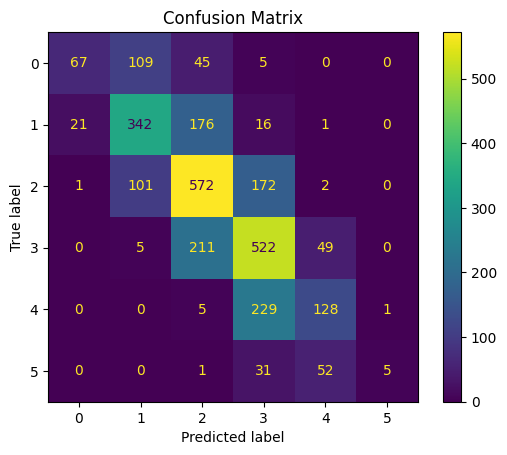

In [38]:
cm = confusion_matrix(oof_df["label"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(CFG.num_labels)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Optimal Thresholds

In [44]:
best, threshold, xs, ys = find_thresholds(oof_df["label"] + 1, oof_df["logit"] + 1, steps=250)

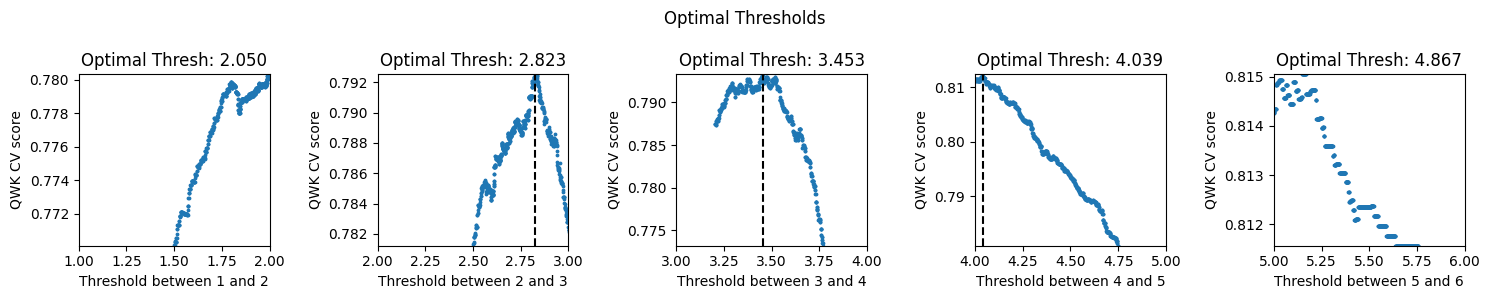

In [45]:
diff = 0.5
nrows, ncols = 1, 5  # Define grid for 5 subplots (1 row, 5 columns)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3))  # Create figure and subplots

# Loop through data and plot on each subplot
for k in range(5):
    ax = axes.flat[k]  # Access each subplot using flattened axes
    ax.scatter(xs[k], ys[k], s=3)
    m = k + 1.5
    ax.set_xlim((m - diff, m + diff))
    i = np.where((np.array(xs[k]) > m - diff) & (np.array(xs[k]) < m + diff))[0]
    mn = np.min(np.array(ys[k])[i])
    mx = np.max(np.array(ys[k])[i])
    ax.set_ylim((mn, mx))

    ax.plot(
        [threshold[k], threshold[k]],
        [mn, mx],
        "--",
        color="black",
        label="optimal threshold",
    )

    ax.set_title(f"Optimal Thresh: {threshold[k]:4.3f}", size=12)  # Adjust title size
    ax.set_xlabel(f"Threshold between {k+1} and {k+2}", size=10)
    ax.set_ylabel("QWK CV score", size=10)

# Common legend for all subplots
plt.suptitle("Optimal Thresholds", size=12)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [46]:
with open(Paths.threshold_path, "wb") as file:
    pkl.dump(threshold, file)

### QWK Score After optimal Thresholding

In [47]:
def raw_to_class(pred, threshold):
    return pd.cut(
        pred,
        [-np.inf] + threshold + [np.inf],
        labels=range(CFG.num_labels),
    ).astype(pd.Int32Dtype())

In [48]:
oof_df["pred_score"] = raw_to_class(oof_df["logit"] + 1, threshold)
score = compute_metrics((oof_df["pred_score"], oof_df["label"]))["qwk"]
print(f"Test dataset QWK score after thresholding: {score}")
wandb.log({"CV/qwk_score_after_threshold": score})

Test dataset QWK score after thresholding: 0.816229845232483


## Wrapping up

In [49]:
wandb.finish()

CV/qwk_score,▁
CV/qwk_score_after_threshold,▁
eval/loss,▂▄▂▃▄▃▁▁▂▁▃▂▁▂▁▇▆█▄▃▃
eval/qwk,▆▆▇▅▄▅▇██▃▁▂▆▅▆▁▄▁▅▆▆
eval/runtime,▆▆▆▄▄▄▆▆▆▁▁▁███▃▃▃▄▄▄
eval/samples_per_second,▅▅▃▁▆▇███▇▇█▇█▇█▇▇▇▇▇
eval/steps_per_second,▅▅▃▁▆████▇▆▇▇█▇▇▇▇▇▇▇
train/epoch,▂▂▄▅▆█▂▃▄▆▆█▂▄▄▆█▁▂▄▅▆▇█▂▄▆▆█▂▃▄▆▇█▂▃▄▆▇
train/global_step,▁▂▄▅▆▇▁▃▄▆▇▁▂▃▅▆▇▁▃▄▆▇█▁▃▄▆▇▁▂▄▅▇█▁▃▄▆▇█
train/grad_norm,▆▂▂▂▂▁▂▂▂▂▁▁█▂▁▁▁▂▁▁▁▂▁▃▂▃▂▁▅▃▂▃▁▁▁▃▂▂▁▁
train/learning_rate,█▇▅▄▂▁█▇▅▃▁▁█▆▄▂▁█▇▆▄▃▁█▇▅▃▂██▆▄▃▁▁▇▆▄▂▁
